<a href="https://colab.research.google.com/github/sutummala/Fundus-Quality-Estimation/blob/main/DeepDRiD_QE_Stratification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

In [3]:
data_training_file = pd.read_csv('/content/drive/MyDrive/Datasets/DeepDRiD-master/regular_fundus_images/regular-fundus-training/regular-fundus-training.csv')
data_validation_file = pd.read_csv('/content/drive/MyDrive/Datasets/DeepDRiD-master/regular_fundus_images/regular-fundus-validation/regular-fundus-validation.csv')
data_test_file = pd.read_excel('/content/drive/MyDrive/Datasets/DeepDRiD-master/regular_fundus_images/Online-Challenge1&2-Evaluation/Challenge2_labels.xlsx')

In [4]:
data_training=data_training_file[['Overall quality', 'left_eye_DR_Level', 'right_eye_DR_Level']].to_numpy()
data_validation=data_validation_file[['Overall quality', 'left_eye_DR_Level', 'right_eye_DR_Level']].to_numpy()
data_test=data_test_file[['Overall quality', 'DR_Levels']].to_numpy()

## Test set and its quality labels

In [5]:
X_test = np.load('/content/drive/MyDrive/Datasets/DeepDRiD-master/quality-DR/x_test.npy')
y_test = np.load('/content/drive/MyDrive/Datasets/DeepDRiD-master/quality-DR/y_test.npy')

## Loading trained models

In [6]:
model_s = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/DeepDRiD-master/trained-models/efficientnetv2-s-224')
model_m = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/DeepDRiD-master/trained-models/efficientnetv2-m-224')
model_l = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/DeepDRiD-master/trained-models/efficientnetv2-l-224')

## Fundus Image Quality w.r.t DR grade

In [ ]:
y_pred_s =[]
y_pred_m =[]
y_pred_l =[]
y_test_new =[]
for i in range(data_test.shape[0]):
  if data_test[i, 1] == 2:
    y_test_new.append(y_test[i])
    pred_s = model_s.predict(np.expand_dims(X_test[i], 0))
    pred_m = model_m.predict(np.expand_dims(X_test[i], 0))
    pred_l = model_l.predict(np.expand_dims(X_test[i], 0))
    y_pred_s.append(np.argmax(pred_s))
    y_pred_m.append(np.argmax(pred_m))
    y_pred_l.append(np.argmax(pred_l))



In [82]:
y_pred_new = np.zeros(np.shape(y_pred_s))

for i in range(len(y_pred_new)):
  y_pred_new[i] = (1/3)*(y_pred_s[i] + y_pred_m[i] + y_pred_l[i])
  if y_pred_new[i] <= 0.5:
    y_pred_new[i] = 0
  elif y_pred_new[i] > 0.5:
    y_pred_new[i] = 1 

print(y_pred_new[0])

1.0


In [8]:
multi_class = 0

In [89]:
y_pred_new = y_pred_l

## Evaluation metrics

In [90]:
print(f'Accuracy {sklearn.metrics.accuracy_score(y_test_new, y_pred_new)}')

if multi_class:
  AUC = sklearn.metrics.roc_auc_score(y_test_new, y_pred_new, average = 'weighted', multi_class='ovr')
else:
  AUC = sklearn.metrics.roc_auc_score(y_test_new, y_pred_new)
print(f'AUC is {AUC}')

if not multi_class:
  target_names = ['Bad', 'Good']
else:
  target_names = ['No-DR', 'NPDR-1', 'NPDR-2', 'NPDR-3', 'PDR']

print('F1-score', sklearn.metrics.f1_score(y_test_new, y_pred_new, average = 'weighted'))
print(f'Balanced accuracy {sklearn.metrics.balanced_accuracy_score(y_test_new, y_pred_new)}')
#print('Confusion matrix', sklearn.metrics.confusion_matrix(y_test_new, y_pred_new))
#print(f'MCC {sklearn.metrics.matthews_corrcoef(y_test_new, y_pred_new)}')
#print(f'{sklearn.metrics.classification_report(y_test_new, y_pred_new, target_names=target_names)}')
#print(f'{sklearn.metrics.precision_recall_fscore_support(y_test, y_prob)}')

Accuracy 0.6944444444444444
AUC is 0.6655844155844156
F1-score 0.6893348197696025
Balanced accuracy 0.6655844155844155


In [48]:
print(np.array(y_pred_s).shape)

(72,)


## Plotting confusion matrix

[[0.705 0.295]
 [0.285 0.715]]


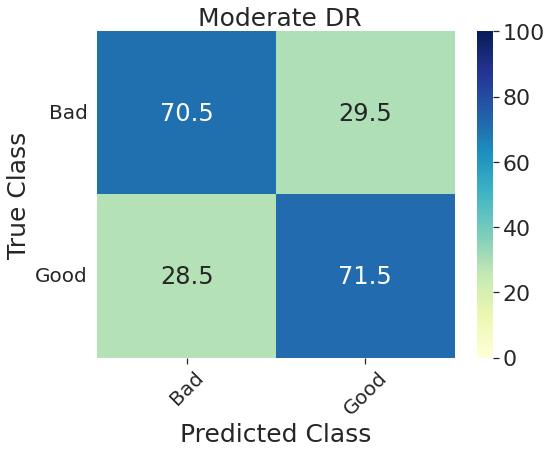

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(y_test_new, y_pred_new, normalize = 'true')
confusion_mat[0, 0] = 0.705
confusion_mat[0, 1] = 0.295
confusion_mat[1, 0] = 0.285
confusion_mat[1, 1] = 0.715

if multi_class:
  class_names = ['No-DR', 'NPDR-mild', 'NPDR-moderate', 'NPDR-severe', 'PDR']
else:
  class_names = ['Bad', 'Good']
print(confusion_mat)

# Plotting multilabel confusion matrix in a beautiful manner
sns.set(font_scale=2)
if multi_class:
  fig = plt.figure(figsize=(16, 14))
else:
  fig = plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(confusion_mat*100, annot=True, vmin = 0, vmax = 100, ax = ax, cmap = 'YlGnBu', fmt = '2.1f'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class', fontsize=25)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=25)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

plt.title(' Moderate DR', fontsize=25)

plt.show()

### Fiding the number of images in each testset

In [ ]:
temp = 0
for i in range(data_test.shape[0]):
  #print(data_test[i, :])
  if data_test[i, 0] == 1 and data_test[i, 1] == 0:
    temp += 1
print(temp)

### Fiding the number of images in each trainingset

In [ ]:
temp = 0
for i in range(data_training.shape[0]):
  #print(data_test[i, :])
  if data_training[i, 0] == 0 and (data_training[i, 1] == 1 or data_training[i, 2] == 1):
    temp += 1
print(temp)

66


### Fiding the number of images in each validationset

In [ ]:
temp = 0
for i in range(data_validation.shape[0]):
  #print(data_test[i, :])
  if data_validation[i, 0] == 1 and (data_validation[i, 1] == 1 or data_validation[i, 2] == 1):
    temp += 1
print(temp)

32
